## Highlights:

This code extracted the the persistent homology features of the handwritten digits images (in the standard MNIST data set). 

For a quick intuitive highlight to verify the correctness of this code, I show the Betti barcode intervals for figures 8 and 7 respectively. The Betti 1 Barcode for 8 shows the death and birth of two bars as we go along the sweep direction, implying that there are two cycles/holes in the image of digit 8. In contrast, no bars appear in the Betti 1 Barcode for 7 as we go along the sweep direction, implying that there are no cycles/holes in the image of digit 7. Such results are exactly what we expect.

**References:**

[1] Aaron Adcock, Erik Carlsson, Gunnar Carlsson, "The Ring of Algebraic Functions on Persistence Bar Codes", Apr 2013. https://arxiv.org/abs/1304.0530

[2] Dmitriy Morozov, "Dionysus 2 documentation". https://mrzv.org/software/dionysus2/

[3] Marko Lalovic, Digits TDA https://github.com/markolalovic



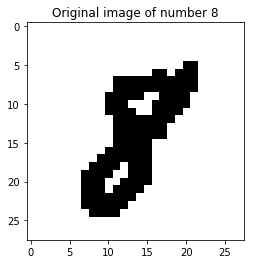

In [58]:
image = get_image(n=17, show=True)

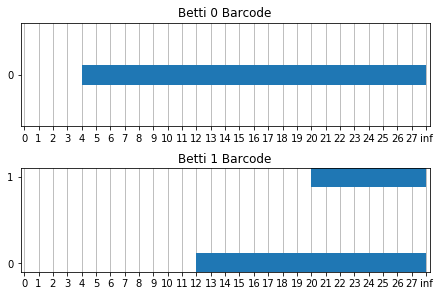

In [ ]:
draw_betti_barcodes(intervals, image_size, show=True)

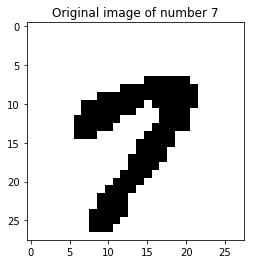

In [59]:
image = get_image(n=15, show=True)

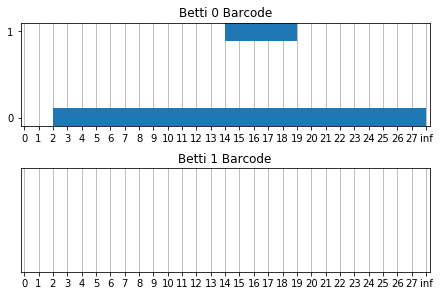

In [ ]:
draw_betti_barcodes(intervals, image_size, show=True)

In [27]:
from google.colab import drive 
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/git-repos/tda-digits/scripts'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/git-repos/tda-digits/scripts


In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
pip install dionysus

     |████████████████████████████████| 1.7MB 5.0MB/s 
  Created wheel for dionysus: filename=dionysus-2.0.8-cp27-cp27mu-linux_x86_64.whl size=323629 sha256=f95bee528d6795059ff3864405ea14717fb1423b5cf7c5ded67f67a2cdf275d1
  Stored in directory: /root/.cache/pip/wheels/91/a9/4e/dcf72861c267c8445765197025f7a02f887fc8f6b43c9c710c
Successfully built dionysus


In [24]:
%cd '/content/drive/My Drive/git-repos/tda-digits/scripts'

/content/drive/My Drive/git-repos/tda-digits/scripts


In [25]:
ls

Classification.ipynb  drawing_module.pyc  prepare_data.py  y_1000.npy
classify_digits.py    draw_mnist.py       tda_digits.py
classify_digits.pyc   draw_torus.py       tda_digits.pyc
drawing_module.py     Example.ipynb       X_1000.npy


Saving to ../figures: 0_original-image.png
Saving to ../figures: 1_binary-image.png
Saving to ../figures: 2_skeleton.png
Saving to ../figures: 3_points.png
Saving to ../figures: 4_embedded-graph.png
Saving to ../figures: 5_simplices.png
Saving to ../figures: 6_betti-barcodes.png
Extracted features: 
[96.0, 0.0, 5308416.0, 0.0, 352.0, 0.0, 11075584.0, 0.0]


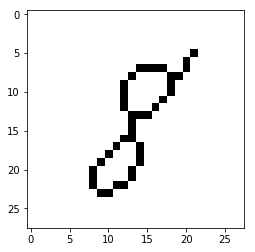

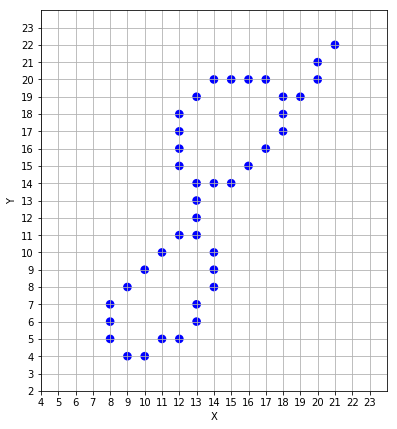

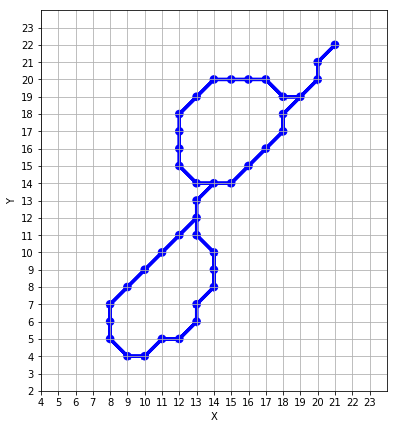

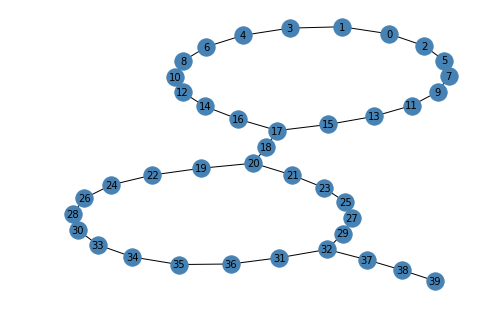

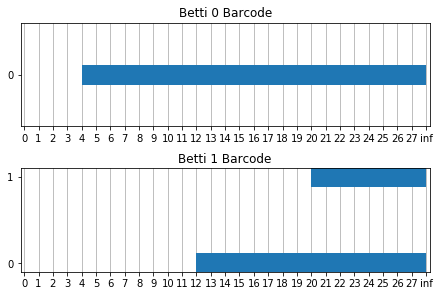

In [33]:
n_samples = 10000 # number of loaded MNIST images
from __future__ import print_function # if you are using Python 2
import dionysus as ds
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from matplotlib import collections  as mc
from sklearn.datasets import load_digits
from skimage.morphology import skeletonize
import math
import sys

from drawing_module import *

if len(sys.argv) == 2:
    print('Setting n_samples to: %i' % (n_samples))
    n_samples = int(sys.argv[1])

n_features = 32 # number of features per image
image_size = 28 # MNIST handwritten digits images are 28x28
# data_X = np.load('/content/drive/MyDrive/git-repos/tda-digits/scripts/X_' + str(n_samples) + '.npy', allow_pickle=True)
# data_y = np.load('/content/drive/MyDrive/git-repos/tda-digits/scripts/y_' + str(n_samples) + '.npy', allow_pickle=True)

data_X = np.load('/content/drive/MyDrive/git-repos/tda-digits/scripts/X_1000.npy', allow_pickle=True)
data_y = np.load('/content/drive/MyDrive/git-repos/tda-digits/scripts/y_1000.npy', allow_pickle=True)

def get_simplices(emb_graph, show=False, save=False):
    ''' 
    This function constructs a simplex stream for computing the persistent homology
    using the filtration on the vertices of the graph G corresponding to the pixels of the image B.
    
    Filtration is the following. We are adding the vertices and edges to the graph G as we sweep across the image B in sweep_direction. 
    In this way we get spatial information from the image B.'''
    simplices = []

    number_of = {}
    for i in range(emb_graph.n):
        node = emb_graph.nodes[i]
        simplices.append( ([i], node.time) )
        number_of[node] = i

    for edge in emb_graph.edges:
        u = number_of[edge.p1]
        v = number_of[edge.p2]
        simplices.append( ([u, v], edge.time) )

    if show:
        graph_nx = nx.Graph()

        for simplex, time in simplices:
            if len(simplex) == 1:
                graph_nx.add_node(simplex[0])
            else:
                edge = (simplex[0], simplex[1])
                graph_nx.add_edge(*edge)

        nx.draw_kamada_kawai(graph_nx,
                font_size=10,
                node_color='steelblue',
                with_labels=True)
        plt.show()

    if save:
        fig = plt.figure()
        graph_nx = nx.Graph()

        for simplex, time in simplices:
            if len(simplex) == 1:
                graph_nx.add_node(simplex[0])
            else:
                edge = (simplex[0], simplex[1])
                graph_nx.add_edge(*edge)

        nx.draw_kamada_kawai(graph_nx,
                font_size=10,
                node_color='steelblue',
                with_labels=True)

        print('Saving to ../figures: 5_simplices.png')
        plt.savefig('../figures/5_simplices.png')

    return simplices

def get_betti_barcodes(simplices, show=False):
    ''' Computes the persistent homology given the simplex stream and persistence diagram.
    Args:
        simplices::list, the simplex stream.
    Returns:
        intervals::dictionary, the Betti barcode intervals for dimensions 0 and 1, for example:
                {0: [[1.0, inf]], 1: [[3.0, inf], [5.0, inf]]}.
    '''
    flt = ds.Filtration()
    for simplex, time in simplices:
        flt.append(ds.Simplex(simplex, time))

    flt.sort()
    homp = ds.homology_persistence(flt)
    dgms = ds.init_diagrams(homp, flt)

    intervals = {}
    intervals[0] = [] # Betti 0 barcodes
    intervals[1] = [] # Betti 1 barcodes
    for i, dgm in enumerate(dgms):
        if show:
            print('Betti', i)
        for pt in dgm:
            intervals[i].append([pt.birth, pt.death])
            if show:
                print('(', pt.birth, ', ', pt.death, ')', sep='')
        if show:
            print()

    return intervals

def get_graph(adj_mat, show=False):
    ''' Transforms the given adjacency matrix representation of a graph to
    the (V, E) graph representation.
    Args:
        adj_mat::numpy.ndarray, Graphs adjacency matrix.
        show::bool.
    Returns:
        G::networkx.Graph(), Graph object.
    '''
    G = nx.Graph()

    # add vertices
    G.add_nodes_from(list(range(adj_mat.shape[0])))

    # add edges
    for i in range(adj_mat.shape[0]):
        for j in range(i+1, adj_mat.shape[1]):
                if adj_mat[i, j] > 0:
                    G.add_edge(i, j)

    if show:
        plt.plot()
        pos = nx.fruchterman_reingold_layout(G, scale=2)
        nx.draw(G,
                pos,
                font_size=10,
                node_color='steelblue',
                with_labels=True,
                font_weight='bold')
        plt.show()

    return G

def get_image(n=17, show=False, save=False):
    ''' Loads the image of a handwritten digit from MNIST dataset.
    Args:
        n::int, the number of the handwritten digit image we want, e.g.:
                n = 17 for image of number 8
                n = 15 for image of number 7.
        show::bool.
    Returns:
        image::numpy.ndarray, array of size image_size x image_size.
    '''
    image = data_X[n]
    image = image.reshape((image_size, image_size))

    if show:
        inverted = np.array(list(map(lambda x: 255.0 - x , image)))
        plt.imshow(inverted, cmap='gray')
        plt.title('Original image of number ' + data_y[n])
        plt.show()

    if save:
        inverted = np.array(list(map(lambda x: 255.0 - x , image)))
        plt.imshow(inverted, cmap='gray')
        print('Saving to ../figures: 0_original-image.png')
        plt.savefig('../figures/0_original-image.png')

    return image

def get_binary_image(image, threshold=0, show=False, save=False):
    ''' Produce the binary image B by thresholding the input image A.
    Args:
        A::numpy.ndarray, the handwritten digit image vector.
        threshold::float, the threshold for binarization. Default is mean(A)/2.
        show::bool.

    Returns:
        B::numpy.ndarray, the binary image of the handwritten digit.
    '''

    if threshold == 0:
        threshold = np.mean(image)
    image[image <= threshold] = 0
    image[image > threshold] = 1

    if show:
        plt.imshow(~image.astype(bool), cmap='gray')
        plt.title('Binary image')
        plt.show()

    if save:
        plt.imshow(~image.astype(bool), cmap='gray')
        print('Saving to ../figures: 1_binary-image.png')
        plt.savefig('../figures/1_binary-image.png')

    return image

def get_skeleton(binary_image, show=False, save=False):
    ''' Reduces the binary image to 1 pixel width to expose its topology
    using the Zhang-Suen Thinning algorithm.
    Args:
        image::numpy.ndarray, the binary image vector.
        show::bool

    Returns:
        skeleton::numpy.ndarray, the skeleton of the input image.
    '''
    binary_image = binary_image.astype(bool)
    skeleton = skeletonize(binary_image)
    skeleton = skeleton.astype(int)

    if show:
        plt.imshow(~skeleton.astype(bool), cmap='gray')
        plt.title('Skeleton of the image')
        plt.show()

    if save:
        plt.imshow(~skeleton.astype(bool), cmap='gray')
        print('Saving to ../figures: 2_skeleton.png')
        plt.savefig('../figures/2_skeleton.png')

    return skeleton

def get_points(skeleton, sweep_direction='top', show=False, save=False):
    ''' Transforms the pixels of skeleton to points.
    Args:
        skeleton::numpy.ndarray, the skeleton image vector 
        sweep_direction::str, assumed to be 'right', 'left', 'top' or 'bottom'.
        show::bool

    Returns:
        points::list, the points of the skeleton of the handwritten digit of a number
                      as a list of Point objects.
    '''
    # transpose and flip the image matrix according to the sweep directions
    if sweep_direction == 'top':
        skeleton = np.flipud(skeleton)
        skeleton = skeleton.transpose()
    elif sweep_direction == 'bottom':
        skeleton = skeleton.transpose()
    elif sweep_direction == 'right':
        skeleton = np.flipud(skeleton)

    coords = skeleton.nonzero()
    coords = list(zip(coords[0], coords[1]))
    points = [Point(coords[i][0], coords[i][1]) for i in range(len(coords))]

    if show:
        canvas = Canvas('Points of the skeleton')
        draw_points(canvas, points)
        canvas.show()

    if save:
        canvas = Canvas('')
        draw_points(canvas, points)
        print('Saving to ../figures: 3_points.png')
        plt.savefig('../figures/3_points.png')

    return points

def draw_betti_barcodes(intervals, xlim, show=False, save=False):
    ''' Draws the Betti barcodes for dimensions 0 and 1.
    Args:
        intervals::dictionary, the Betti barcode intervals for dimensions 0 and 1, e.g.:
                {0: [[1.0, inf]], 1: [[3.0, inf], [5.0, inf]]}
        xlim::float, the plots limit for x axis.
    '''
    lines = {}
    lines[0] = []
    lines[1] = []
    for dim in [0, 1]:
        for i in range(len(intervals[dim])):
            a, b = intervals[dim][i]
            if str(b) == 'inf':
                b = xlim
            lines[dim].append([(a, i), (b, i)]) # draw it at height i

    fig, axs = pl.subplots(2, 1, constrained_layout=True)
    fig.canvas.draw()


    xticks = list(range(xlim + 1))
    xlabels = [str(i) for i in range(xlim)] + ['inf']

    for dim in [0, 1]:
        lc = mc.LineCollection(lines[dim], linewidths=20)

        axs[dim].set_aspect('auto')
        axs[dim].set_xlim([-.25, xlim + .25])
        axs[dim].set_xbound(lower=-.25, upper=xlim + .25)

        axs[dim].add_collection(lc)

        axs[dim].set_xticks(xticks)
        axs[dim].set_xticklabels(xlabels)

        yticks = list(range(len(lines[dim])))
        ylabels = [str(i) for i in yticks]
        axs[dim].set_yticks(yticks)
        axs[dim].set_yticklabels(ylabels)

        axs[dim].xaxis.grid(True)
        axs[dim].margins(0.1)
        axs[dim].set_title('Betti ' + str(dim) + ' Barcode');

    if show:
        pl.show()
    if save:
        print('Saving to ../figures: 6_betti-barcodes.png')
        pl.savefig('../figures/6_betti-barcodes.png')

def extract_features(intervals):
    ''' Extracts 4 features:
        	sum_i { x_i * (y_i - x_i) }
        	sum_i { (y_max - y_i) * (y_i - x_i) }
        	sum_i { x_i^2 * (y_i - x_i)^4 }
        	sum_i { (y_max - y_i)^2 * (y_i - x_i)^4 }
    From the barcode intervals:
        (x1, y1), (x2, y2), ..., (x_n, y_n);
    Args:
        intervals::list, the Betti barcode intervals, e.g.: [[3.0, inf], [5.0, inf]]
    Returns:
        features::list, the list of the 4 computed features.
    '''
    xs = []
    ys = []
    for interval in intervals:
        x = interval[0]
        y = interval[1]
        if str(y) == 'inf': # replace the inf with image_size
            y = image_size
        xs.append(x)
        ys.append(y)

    f1, f2, f3, f4 = 0., 0., 0., 0.
    for i in range(len(xs)):
        f1 += xs[i] * (ys[i] - xs[i])
        f2 += (max(ys) - ys[i]) * (ys[i] - xs[i])
        f3 += math.pow(xs[i], 2) * math.pow(ys[i] - xs[i], 4)
        f4 += math.pow(max(ys) - ys[i], 2) * math.pow(ys[i] - xs[i], 4)

    return [f1, f2, f3, f4]

def extract_all_features(n):
    ''' Extracts features of nth image:
            4 sweeps * (2 barcodes * 4 features) = 32 features
        Args:
            n::int, the index of the handwritten digit image, e.g.:
                    n = 17 for image of digit 8
                    n = 15 for image of digit 7
        Returns:
            all_features::list, the list of 32 computed features.
    '''
    image = get_image(n)
    binary_image = get_binary_image(image)
    skeleton = get_skeleton(binary_image)

    all_features = []
    for sweep_direction in ['right', 'left', 'top', 'bottom']:
        points = get_points(skeleton, sweep_direction)
        point_list = PointList(points)
        emb_graph = point_list.get_emb_graph()
        simplices = get_simplices(emb_graph)
        intervals = get_betti_barcodes(simplices)

        f0 = extract_features(intervals[0])
        f1 = extract_features(intervals[1])
        features = f0 + f1
        all_features += features

    return all_features

def save_features_matrix(n_samples=1000):
    ''' Saves the feature matrix of shape (n_samples, n_features).
        Args:
            n_samples::int, number of samples of handwritten digit images.
    '''
    df = np.zeros((n_samples, n_features))

    # extract all features of each image and save it to an array
    print('Extracting all features...')
    for n in range(n_samples):
        df[n] = extract_all_features(n)

    print('Features extracted.')
    # np.save('../data/' + 'features_' + str(n_samples) + '.npy', df)
    

# Demo: feature extraction from handwritten digits (MNIST)

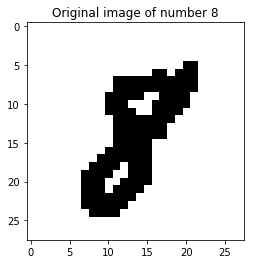

In [37]:
image = get_image(n=17, show=True)

Produce the binary image B by thresholding the input image:

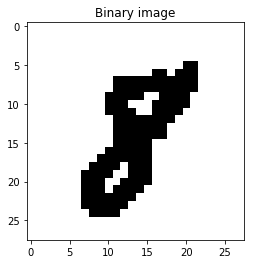

In [38]:
binary_image = get_binary_image(image, show=True)

Reduce the binary image to 1 pixel width to expose its topology using the Zhang-Suen Thinning algorithm:

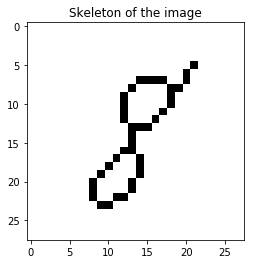

In [39]:
skeleton = get_skeleton(binary_image, show=True)

Transform the pixels of skeleton to points in the plane:

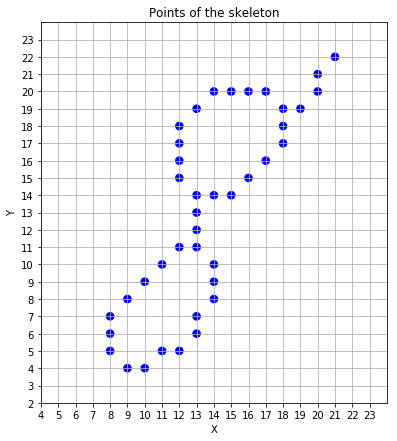

In [40]:
points = get_points(skeleton, sweep_direction='top', show=True)

Construct an embedded graph G in the plane where we treat the points as vertices and add edges between adjacent points similar to [1] and then remove all cycles of length 3. Intuitively, we connect the points while trying not to create new topological features.

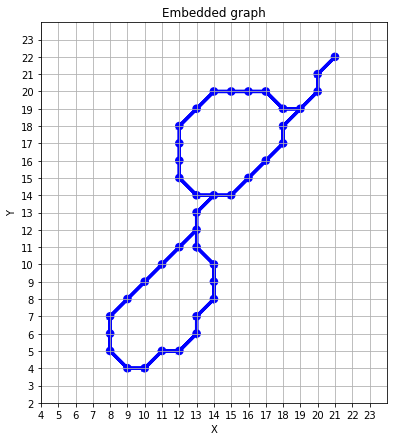

In [ ]:
point_list = PointList(points)
emb_graph = point_list.get_emb_graph(show=True)

Construct a simplex stream for computing the persistent homology using the filtration on the vertices of the graph G. Filtration is the following. We are adding the vertices and edges of the embedded graph G as we sweep across the plane in sweep_direction. In this example, we sweep across the plane from $y = -\inf$ to $y = \inf$:

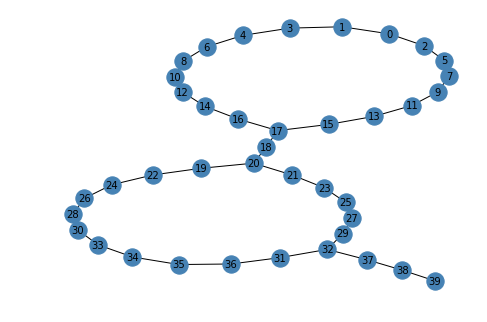

In [ ]:
simplices = get_simplices(emb_graph, show=True)

Compute the persistent homology given the simplex stream to get the so-called Betti barcodes.

*Betti $k$ barcode* is a finite set of intervals. Each interval represents the first filtration level where the topological feature of dimension $k$ appears and the filtration level where it disappears. This are called birth and death times of the topological feature. 

A connected component (connected cluster of points) is 0 dimensional and a cycle (loop) is 1 dimensional feature. 

In [ ]:
intervals = get_betti_barcodes(simplices, show=True)

Betti 0
(4.0, inf)

Betti 1
(12.0, inf)
(20.0, inf)



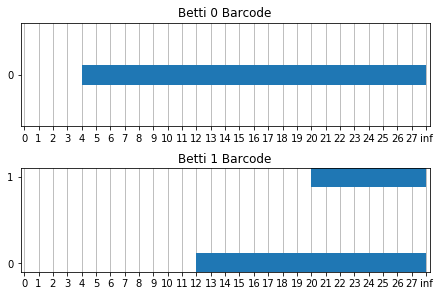

In [ ]:
draw_betti_barcodes(intervals, image_size, show=True)

We note that the Betti 0 barcode (the upper picture) clearly shows the single connected component with the birth time of 4.

The Betti 1 barcode shows two lines with birth times 12 and 20 corresponding to the births of 2 cycles (the value of y when the loop closes) in the drawing of number 8 when we sweep in $y$ direction across the plane from $y = -\inf$ to $y = \inf$.

Extract 4 features:
$$
        	\sum_i { x_i (y_i - x_i) } \\
        	\sum_i { (y_{\text{max}} - y_i) (y_i - x_i) } \\
        	\sum_i { x_i^2 \cdot (y_i - x_i)^4 } \\
        	\sum_i { (y_{\text{max}} - y_i)^2 (y_i - x_i)^4 }
$$
From each Betti barcode intervals:
$$
        (x1, y1), (x2, y2), ..., (x_n, y_n)
$$

In [ ]:
extract_features(intervals[0])

[96.0, 0.0, 5308416.0, 0.0]

In [ ]:
extract_features(intervals[1])

[352.0, 0.0, 11075584.0, 0.0]

There are 4 sweep directions: top, bottom, right, left. We compute 2 barcodes for 0 and 1 dimension with 4 features each. All together 32 features per image of a handwritten digit:
$$
4 \text{ sweeps } \cdot 2 \text{ barcodes } \cdot 4 \text{ features } = 32 \text{ features }
$$

In [ ]:
all_features = extract_all_features(n=17)
print(len(all_features))

32


In [ ]:
all_features

[184.0,
 28.0,
 10242304.0,
 3136.0,
 367.0,
 0.0,
 9898057.0,
 0.0,
 184.0,
 28.0,
 10242304.0,
 3136.0,
 367.0,
 0.0,
 9898057.0,
 0.0,
 96.0,
 0.0,
 5308416.0,
 0.0,
 352.0,
 0.0,
 11075584.0,
 0.0,
 129.0,
 38.0,
 6996809.0,
 5776.0,
 311.0,
 0.0,
 7860161.0,
 0.0]

### Do the same for digit 7:

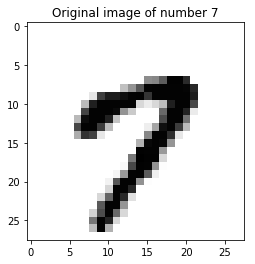

In [41]:
image = get_image(n=15, show=True)

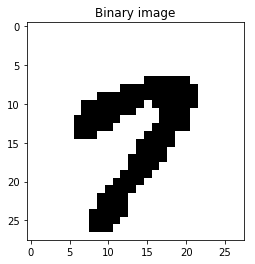

In [42]:
binary_image = get_binary_image(image, show=True)

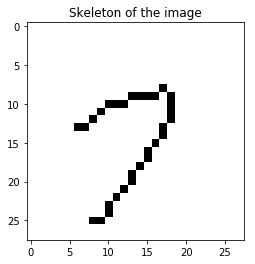

In [43]:
skeleton = get_skeleton(binary_image, show=True)

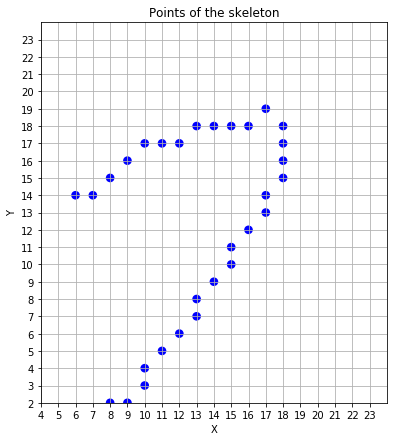

In [44]:
points = get_points(skeleton, sweep_direction='top', show=True)

In [45]:
point_list = PointList(points)

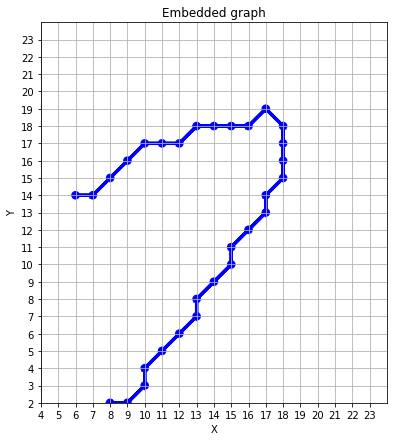

In [46]:
emb_graph = point_list.get_emb_graph(show=True)

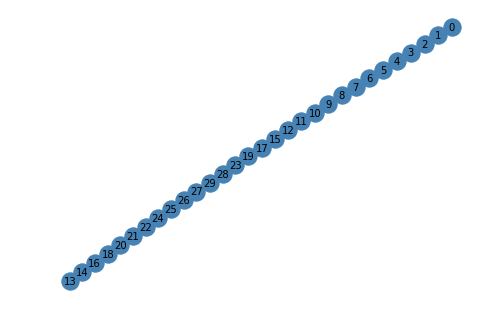

In [47]:
simplices = get_simplices(emb_graph, show=True)

In [48]:
intervals = get_betti_barcodes(simplices, show=True)

Betti 0
(2.0, inf)
(14.0, 19.0)

Betti 1



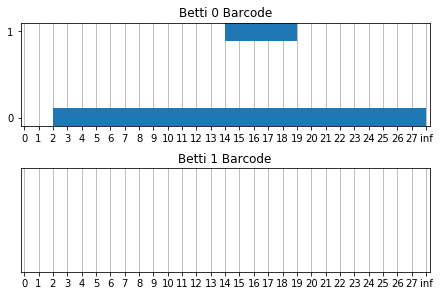

In [49]:
draw_betti_barcodes(intervals, image_size, show=True)

In [50]:
extract_features(intervals[0])

[122.0, 45.0, 1950404.0, 50625.0]

In [51]:
extract_features(intervals[1])

[0.0, 0.0, 0.0, 0.0]

In [55]:
all_features = extract_all_features(n=15)

In [56]:
print(len(all_features))

32


In [57]:
all_features

[212.0,
 100.0,
 9073216.0,
 1000000.0,
 0.0,
 0.0,
 0.0,
 0.0,
 212.0,
 100.0,
 9073216.0,
 1000000.0,
 0.0,
 0.0,
 0.0,
 0.0,
 122.0,
 45.0,
 1950404.0,
 50625.0,
 0.0,
 0.0,
 0.0,
 0.0,
 160.0,
 0.0,
 10240000.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]